In [ ]:
pip install svgpathtools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 6.7 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/JASCRAJ/stylized-neural-painting.git

Cloning into 'stylized-neural-painting'...
remote: Enumerating objects: 257, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 257 (delta 104), reused 61 (delta 61), pack-reused 110 (from 1)
Receiving objects: 100% (257/257), 11.01 MiB | 19.58 MiB/s, done.
Resolving deltas: 100% (134/134), done.


In [ ]:
cd stylized-neural-painting

/content/stylized-neural-painting


In [ ]:
import gdown
import zipfile
import os


gdrive_link = 'https://drive.google.com/file/d/1sqWhgBKqaBJggl2A8sD1bLSq2_B1ScMG/view?usp=sharing'

# Extract the file ID from the link
file_id = gdrive_link.split('/d/')[1].split('/')[0]
download_url = f'https://drive.google.com/uc?id={file_id}'

#Download the ZIP file
output = 'checkpoints_G_oilpaintbrush.zip'
gdown.download(download_url, output, quiet=False)

# Unzip the file
unzip_path = '/content/stylized-neural-painting/'
os.makedirs(unzip_path, exist_ok=True)

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

print(f"Files extracted to: {unzip_path}")


Downloading...
From (original): https://drive.google.com/uc?id=1sqWhgBKqaBJggl2A8sD1bLSq2_B1ScMG
From (redirected): https://drive.google.com/uc?id=1sqWhgBKqaBJggl2A8sD1bLSq2_B1ScMG&confirm=t&uuid=9945cc14-a106-4e3a-828e-1a4b813039f5
To: /content/stylized-neural-painting/checkpoints_G_oilpaintbrush.zip
100%|██████████| 181M/181M [00:03<00:00, 54.4MB/s]


Files extracted to: /content/stylized-neural-painting/


initialize network with normal
loading renderer from pre-trained checkpoint...
(5805, 5)
(5805, 6)
(5805, 1)
rendering canvas...
✓ Painting saved to reconstructed_prog.png


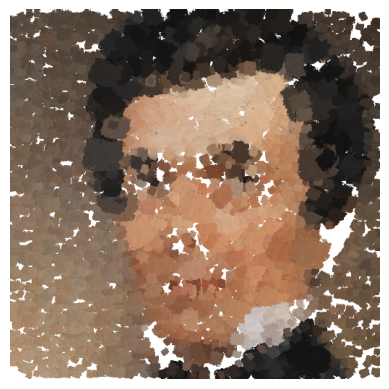

In [ ]:
# -------------------------------------------------------------
# Re‑render strokes saved by demo_prog.py
# -------------------------------------------------------------
import os, cv2, torch, numpy as np
from types import SimpleNamespace
from PIL import Image
from painter import ProgressivePainter        # same class used in demo_prog.py

# --- paths -------------------------------------------------
NPZ_FILE   = './my_strokes.npz'           # <‑‑ change if needed
CKPT_DIR   = '/content/stylized-neural-painting/checkpoints_G_oilpaintbrush'    # folder with Gs.pth / Gr.pth
OUT_PNG    = 'reconstructed_prog.png'

# ---  Painter‑args object ------------------------------
args = SimpleNamespace(
    img_path='',         # dummy photo so ProgressivePainter works
    renderer='oilpaintbrush',
    renderer_checkpoint_dir=CKPT_DIR,
    net_G='zou-fusion-net',
    canvas_color='white',
    canvas_size=512,
    max_divide=5,                 # <<‑‑ use SAME value as in demo_prog.py
    max_m_strokes=5805,
    keep_aspect_ratio=False,
    beta_L1=1.0,
    with_ot_loss=False,
    beta_ot=0.1,
    lr=0.002,
    output_dir='./output',
    disable_preview=True,
)



# ---  building ProgressivePainter & load renderer --------------
pp = ProgressivePainter(args=args)
pp.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pp._load_checkpoint()                 # loads Gs.pth / Gr.pth
pp.net_G.eval()

# ---  loading stroke parameters --------------------------------
data = np.load(NPZ_FILE)
if 'stroke_params' in data:           # some forks store a single array
    params = data['stroke_params']    # shape (1, N, 12)
else:                                 # official repo format: ctt/color/alpha
    params = np.concatenate([data['x_ctt'],
                             data['x_color'],
                             data['x_alpha']], axis=-1)   # (1, N, 12)

print(data['x_ctt'].shape)
print(data['x_color'].shape)
print(data['x_alpha'].shape)

if params.ndim == 2:
    params = params[np.newaxis, ...]  # now shape is (1, N, 12)

# --- rendering   ----------------------------------------------
canvas = pp._render(params, save_jpgs=False, save_video=False)  # H×W×3 float32

# ---  save + display ----------------------------------------
img = Image.fromarray((canvas * 255).clip(0, 255).astype(np.uint8))
img.save(OUT_PNG)
print(f'✓ Painting saved to {OUT_PNG}')


import matplotlib.pyplot as plt
plt.imshow(img)
plt.axis('off')
plt.show()


**Lets optimize further to get clear image
**

**opt_strokes.py hepls us to optimize our npz file to get clear image**

In [ ]:
!python opt_strokes.py \
  --img_path "    "\#  give same image from where you extracted JSON file
  --canvas_color white \
  --max_m_strokes 4805 \
  --max_divide 5 \
  --renderer oilpaintbrush \
  --renderer_checkpoint_dir checkpoints_G_oilpaintbrush \
  --net_G zou-fusion-net \
  --output_dir ./output \
  --init_strokes my_strokes.npz     # <‑‑ new!
